In [13]:
import random
from numpy import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import datetime
import os
import pandas as pd
import itertools

STAY = 0
LEAVE = 1

OFF = 0
ON = 1


In [14]:
class Agent:
    def __init__(self,nActions,integration_dim,num_timesteps,ITI_len,epsilon = .5,baseline_epsilon = 0,omniscient = False):
        self.Q = [np.zeros((nActions,ITI_len)),np.zeros((nActions,integration_dim,num_timesteps))]
        self.epsilon0 = epsilon
        self.epsilon = epsilon # proportion of exploration
        self.baseline_epsilon = baseline_epsilon
        self.Lambda = 0.8 # eligibility trace decay
        self.lr = 0.1 # learning rate
        self.discount = .7
        self.omniscient = omniscient
        
    def select_action(self,internal_state):
        """
            Agent chooses an action
            Returns: new action
        """
        if rnd.random() > self.epsilon:
            return self.greedy_action(internal_state)
        else:
            return self.random_action()
            
    def random_action(self):
        """
            Agent takes a random action
        """
        return STAY if random.random() < 0.5 else LEAVE
    
    def greedy_action(self,internal_state):
        """
            Agent takes most rewarding action in current state according to Q table
        """
#         print(internal_state[1:])
        if self.Q[internal_state[0]][(STAY,)+internal_state[1:]] > self.Q[internal_state[0]][(LEAVE,)+internal_state[1:]]:
            return STAY
        # Is LEAVE reward bigger?
        elif self.Q[internal_state[0]][(LEAVE,)+internal_state[1:]] > self.Q[internal_state[0]][(STAY,)+internal_state[1:]]:
            return LEAVE
        # Rewards are equal, take random action
        return STAY if random.random() < 0.5 else LEAVE   
        
    def update(self, old_state, new_state, action, reward):
        """
            Update agent Q-table based on experience
            Arguments: old_state,new_state,action,reward
        """
#         if action == LEAVE:
#             # this should never be nonzero!
#             print('LEAVE reward:',reward)
#         print((LEAVE,)+old_state[1:])
#         testleave = self.Q[old_state[0]][(LEAVE,)+old_state[1:]]
#         teststay = self.Q[old_state[0]][(STAY,)+old_state[1:]]
        q_old = self.Q[old_state[0]][(action,)+old_state[1:]] # Old Q-table value
        future_action = self.greedy_action(new_state) # Select next best action
        #  print('future_action:',future_action)
        EV_new = self.Q[new_state[0]][(future_action,)+new_state[1:]] # What is reward for the best next action?
        
        # Main Q-table updating algorithm
#         new_value = q_old + self.lr * (reward + self.discount * EV_new - q_old) # add lambda here
#         print(self.Q[action][old_state])
#         self.Q[action][old_state] = new_value

        self.Q[old_state[0]][(action,)+old_state[1:]] += self.lr * (reward + self.discount * EV_new - q_old)
        
#         print(self.Q[action][old_state])
#         print('action:',action)
#         testleave2 = self.Q[old_state[0]][(LEAVE,)+old_state[1:]]
#         teststay2 = self.Q[old_state[0]][(STAY,)+old_state[1:]]
        
#         print('leave:',testleave,'->',testleave2)
#         print('stay:',teststay,'->',teststay2)


In [15]:
# Methods to draw from discrete expo distributions for Patch Environment
def cdf(x,N0):
    A = -.125
    return 1+ N0 * 1/A * np.exp(A*x) - N0/A
def pdf(this_cdf):
    this_pdf = []
    for t in range(1,len(this_cdf)):
        this_pdf.append(this_cdf[t]-this_cdf[t-1])
    this_pdf.insert(0,1) # add that first reward
    return this_pdf

def generate_pdfs(N0):
    pdfs = dict()
    for n0 in N0:
        x = list(map(cdf,list(range(50)),np.full(50,n0)))
        pdfs[n0] = pdf(x)
    return pdfs

In [16]:
# virtual patch environment
class PatchEnvironment():
    """
        Virtual foraging environment
        This only does two things:
            1. Return rewards on probabilistic or deterministic reward schedules
            2. Return patch ON state or patch OFF state
            3. Does need to keep track of time for logging purposes?
            3.5. Log output data as this is what is going to match what we observe?
    """
    def __init__(self,rew_system = 'deterministic',nTimestates = 50,ITI_len = 5):
        self.rew_system = rew_system
        self.nTimestates = nTimestates
        self.ITI_len = ITI_len
        self.N0 = [.5, .25, .125]
        self.pdfs = generate_pdfs(self.N0)
        self.rewsizes = [1, 2, 4] 
        self.state = [OFF,0] # start with the patch off with no distance run
        
    def execute_action(self, action):
        """
            Environment changes state, returns reward based on agent action
            Arguments: action {STAY or LEAVE}
            Returns: new state, reward
        """
        if action == STAY and self.state[0] == ON: 
            self.state[1] += 1 # increment time on patch
            rew = self.curr_rews[self.state[1]] # give reward acc to current schedule
        elif action == LEAVE and self.state[0] == ON: # leave patch
            self.state = [OFF,0]
            rew = 0
            
        elif action == STAY and self.state[0] == OFF:
            # state stays the same
            rew = 0
        elif action == LEAVE and self.state[0] == OFF:
            self.state[1] += 1
            if self.state[1] == self.ITI_len:
                self.new_patch() # this changes the env state
                rew = self.curr_rews[0] # deliver the first reward
            else:
                rew = 0
        return self.state, rew
        
    def new_patch(self):
        self.curr_rews = np.zeros(self.nTimestates)
        
        curr_rewsize = rnd.choice(self.rewsizes)
        curr_rewfreq = rnd.choice(self.N0)
        
        self.curr_freq = curr_rewfreq
        self.curr_rewsize = curr_rewsize

        if self.rew_system == 'deterministic':
            self.curr_rews[[0,4,16]] = curr_rewsize
        if self.rew_system == 'probabilistic':
            curr_rewlocs = np.where(rnd.random(50) - self.pdfs[curr_rewfreq] < 0)[0].tolist()
            self.curr_rews[curr_rewlocs] = curr_rewsize
            
        self.state = [ON,0]        
        
class RewSizeAgent(Agent):
    """
        Agent processes only the reward size in the q table
    """
    def __init__(self,nTimestates,rewsizes,ITI_len,epsilon = .5,baseline_epsilon = .1):
        nActions = 2
        super().__init__(nActions,len(rewsizes),nTimestates,ITI_len,epsilon = epsilon,baseline_epsilon = baseline_epsilon)
        self.curr_rewsize = 0
        self.rewsizes = rewsizes
    
    def internalize_state(self,env_state):
        """
            Use agent memory of the current reward size and env information on time
            returns internal_state = (curr_rewsize,time on patch) as a tuple for array indexing
        """
        if env_state[0] == ON:
            internal_state = tuple((ON,self.rewsizes.index(self.curr_rewsize),env_state[1]))
        else:
            internal_state = tuple(env_state)
        return internal_state
    
    def integrate(self,rew):
        self.curr_rewsize = rew
        
    def reset_integration(self):
        self.curr_rewsize = 0
    
class TotalRewAgent(Agent):
    """
        Agent has memory of rewards received and processes this as part of Q table
    """
    def __init__(self,nTimestates,max_rewsize,ITI_len,epsilon = .5,baseline_epsilon = .1):
        max_totalrew = nTimestates * max_rewsize
        print(max_totalrew)
        nActions = 2    
        super().__init__(nActions,max_totalrew,nTimestates,ITI_len,epsilon = epsilon,baseline_epsilon = baseline_epsilon)
        self.elg_states = []
        self.curr_totalrew = 0
        
    def internalize_state(self,env_state):
        """
            Use agent memory of total rew received on current patch and env information on time
            returns internal_state = (curr_totalrew,time on patch)
        """
        if env_state[0] == ON:
            internal_state = tuple((ON,self.curr_totalrew,env_state[1]))
        else:
            internal_state = tuple(env_state)
        return internal_state
    
    def integrate(self,rew):
        self.curr_totalrew += int(rew)
    
    def reset_integration(self):
        self.curr_totalrew = 0
        
class OmniscentAgent(Agent):
    """
        Agent has perfect knowledge of patch reward size and frequency
    """
    def __init__(self,nTimestates,rewsizes,freqs,ITI_len,epsilon = .5,baseline_epsilon = .1):
        nActions = 2
        nPatches = int(len(rewsizes) * len(freqs))
        super().__init__(nActions,nPatches,nTimestates,ITI_len,epsilon = epsilon,baseline_epsilon = baseline_epsilon,omniscient = True)
        self.rewsizes = rewsizes
        self.freqs = freqs
        self.patches = list(itertools.product([0,1,2], repeat = 2))
        self.curr_patch = 0
        
    def internalize_state(self,env_state):
        """
            grab the patch and time spent on patch
            returns internal_state as a tuple for indexing q table
        """
        if env_state[0] == ON:
            internal_state = tuple((ON,self.curr_patch,env_state[1]))
        else:
            internal_state = tuple(env_state)
        return internal_state
    
    def integrate(self,curr_rewsize,curr_freq):
        """
            Returns a patch between 0 and 8
        """
        self.curr_patch = self.patches.index((self.rewsizes.index(curr_rewsize),self.freqs.index(curr_freq)))
    
    def reset_integration(self):
        self.curr_patch = 0
        

In [168]:
class RLInterface():
    """
        Bring together an agent and an environment and THROW DOWN
        Methods: step, run_trials
    """
    def __init__(self,agent,environment):
        self.agent = agent
        self.env = environment
    
    def step(self,record_decisions):
        old_state = self.env.state # get env state
        internal_old_state = self.agent.internalize_state(old_state) # internalize old env state
        action = agent.select_action(internal_old_state) # agent selects action
        new_state,rew = self.env.execute_action(action) # execute agent action into the environment
        if rew > 0:
            if self.agent.omniscient != True:
                self.agent.integrate(rew)
            else:
                self.agent.integrate(env.curr_rewsize,env.curr_freq)
        internal_new_state = self.agent.internalize_state(new_state) # internalize new env state
        self.agent.update(internal_old_state, internal_new_state, action, rew) # update Q 
        if record_decisions == True:
            return action,rew
        
    def run_trials(self,nTrials,epsilon_decay = 0,record_decisions = False):
        if record_decisions == True:
            decisions = []
            self.prts = {1:[],2:[],4:[]}
            self.rew_locs = {1:[],2:[],4:[]}
            self.prts_plus = {1:{.125:[],.25:[],.5:[]},
                              2:{.125:[],.25:[],.5:[]},
                              4:{.125:[],.25:[],.5:[]}}
            self.rews = []
            
        for iTrial in range(nTrials):
            while self.env.state[0] == OFF: # start with patch off
                self.step(record_decisions)
            # patch on, record parameters
            self.curr_rew = int(self.env.curr_rews[0])
            self.rew_locs[self.curr_rew].append(self.env.curr_rews)
            self.curr_freq = self.env.curr_freq
            self.curr_prt = 0
            while self.env.state[0] == ON: # now allow for behavior on the patch
                if record_decisions == True:
                    action,rew = self.step(record_decisions)
                    self.curr_prt += 1
                    decisions.append(action)
                    self.rews.append(rew)
                else:
                    self.step(record_decisions)
                    
            self.prts[self.curr_rew].append(self.curr_prt)
            self.prts_plus[self.curr_rew][self.curr_freq].append(self.curr_prt)
            
            self.agent.reset_integration()
            self.agent.epsilon = self.agent.epsilon0 * np.e**(-iTrial/epsilon_decay) + self.agent.baseline_epsilon
            
        if record_decisions == True:
            return decisions
    
    def show_qtable(self):
        """
            A visualization method to analyze how the agent is making decisions
        """
        plt.figure(figsize = (10,3))
        plt.subplots_adjust(hspace = 15,wspace = .5)
        plt.suptitle('Agent Q Table',x=.5,y=1.05)
        plt.subplot(1,3,1)
        plt.title('Patch ON STAY Q table')
        sns.heatmap(self.agent.Q[1][0,:30,0:12])
        plt.subplot(1,3,2)
        plt.title('Patch ON LEAVE Q table')
        sns.heatmap(self.agent.Q[1][1,:30,0:12])
        plt.subplot(1,3,3)
        plt.title('Patch OFF Q table')
        sns.heatmap(self.agent.Q[0])
        plt.show()
    
    def plot_percent_stay(self,decisions):
        """
            Just visualize the proportion of stay decisions agent is making on the patch
        """
        percent = [1 - sum(decisions[0:i])/i for i in range(1,len(decisions))]
        plt.figure()
        plt.title('Percent of STAY choice on patch over time')
        plt.ylim([0,1])
        plt.plot(percent)

    def plot_prts(self,resolution):
        """
            Visualize smoothed PRTs over learning, separated by patch type
            Use this to determine around where behavior stabilizes
        """
        plt.figure()
        for patch in self.prts.keys():
            coords = list(range(0,len(self.prts[patch])-resolution,resolution))
            smoothened = [np.mean(self.prts[patch][coords[i]:coords[i+1]]) for i in range(len(coords)-1)]
            plt.plot(smoothened,label = str(str(patch) + ' uL'))
        plt.legend()
        plt.ylabel('Avg Patch Residence Time')
        plt.xlabel('Time over training')
        plt.title('Patch-Separated Evolution of PRTs over Training')
    
    def plot_rewrate(self,resolution,agent_type):
        """
            Visualize smoothed rewrate over course of learning
            Use this to determine around where behavior stabilizes and how efficient the algorithm is
        """
        plt.figure()
        coords = list(range(0,len(self.rews)-resolution,resolution))
        smoothened = [np.mean(self.rews[coords[i]:coords[i+1]]) for i in range(len(coords)-1)]
        plt.plot(smoothened)
        plt.ylabel('Avg Rew/sec')
        plt.ylim([.3,.6])
        plt.xlabel('Time over training')
        plt.title('Rew/sec over Training for ' + agent_type + ' Agent')
        display("Mean:",np.mean(self.rews))
        display("Std:",np.std(self.rews))

    def prt_bars(self,start):
        """
            Visualize proportion of stay decisions agent makes on patch, separated by patch type
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
        """
        data = []
        lengths = []
        for patch in self.prts.keys():
            data.append(self.prts[patch])
            lengths.append(len(np.array(self.prts[patch])))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        self.patch_df = pd.DataFrame(array_prts,columns = ['Sm','Md','Lg'])
        
        plt.figure()
        ax = sns.barplot(data = self.patch_df,palette = [(0,0,0),(.5,1,1),(0,0,1)],edgecolor=".2")
        plt.xlabel('Rew Size (uL)')
        plt.ylabel('Mean PRT (sec)')
        plt.title('PRT by Reward Size')
        plt.show()
    
    def prt_hist(self,start):
        """
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
            Basically a more detailed visualization of the prt_bars
        """
        data = []
        lengths = []
        for patch in self.prts.keys():
            data.append(self.prts[patch])
            lengths.append(len(np.array(self.prts[patch])))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        array_prts = array_prts + rnd.normal(0,.3,array_prts.shape)
        self.patch_df = pd.DataFrame(array_prts,columns = ['Sm','Md','Lg'])
        
        plt.figure(figsize = [5,15])
        # ax = sns.barplot(data = self.patch_df,palette = [(0,0,0),(.5,1,1),(0,0,1)],edgecolor=".2")
        plt.subplot(3,1,1)
        plt.title('1 uL Rewsize')
        sns.distplot(self.patch_df["Sm"], color=(0,0,0), hist=False, rug=False)
        plt.subplot(3,1,2)
        plt.title('2 uL Rewsize')
        sns.distplot(self.patch_df["Md"], color=(.5,1,1), hist=False, rug=False)
        plt.subplot(3,1,3)
        plt.title('4 uL Rewsize')
        sns.distplot(self.patch_df["Lg"], color = (0,0,1),hist=False, rug=False)

        # plt.xlabel('Rew Size (uL)')
        plt.suptitle('PRT Distribution by Reward Size')
        plt.show() 
            
    def prt_plus_bars(self,start):
        """
            Visualize mean PRT separated by reward size and frequency
            Input start parameter, where we start analysis based on convergence after plot_prts analysis
        """
        data = []
        lengths = []
        for rew_size in self.prts_plus.keys():
            for rew_freq in self.prts_plus[rew_size].keys():
                data.append(self.prts_plus[rew_size][rew_freq])
                lengths.append(len(self.prts_plus[rew_size][rew_freq]))
        min_len = min(lengths)
        array_prts = np.array([data[i][start:min_len] for i in range(len(data))]).T
        self.patch_plus_df = pd.DataFrame(array_prts,columns = ['1uL Lo','1uL Md','1uL Hi','2uL Lo','2uL Md','2uL Hi','4uL Lo','4uL Md','4uL Hi'])

        colors = [(.5,.5,.5),(.3,.3,.3),(0,0,0),(.9,1,1),(.7,1,1),(.5,1,1),(.5,.5,1),(.3,.3,1),(0,0,1)]
        plt.figure()
        ax = sns.barplot(data = self.patch_plus_df,palette = colors,edgecolor=".2")
        plt.xlabel('Rew Size (uL)')
        plt.ylabel('Mean PRT (sec)')
        plt.title('PRT by Reward Size and Frequency')
        plt.show()
    
    def mk_timecourse(self):
        """
            Convert PRTs into 'trial timecourses', binary vectors 0 if we have left patch, 1 if we are still on
        """
        data = self.prts
        num_timesteps = 40

        self.timecourses = dict()
        for patch in data.keys(): # could make this a double list comp but i still hold some mercy in my heart
#             for prt in data[patch]:
#                 print(prt)
            self.timecourses[patch] = np.array([list(np.ones(prt)) + list(np.zeros(num_timesteps-prt)) for prt in data[patch]])
    
    def plot_survival(self):
        """
            Plot timecourses in terms of survival curves separated by patch
        """
        plt.figure()
        colors = {1:(0,0,0),2:(.5,1,1),4:(0,0,1)}
        for patch in self.timecourses.keys():
            survival = np.sum(self.timecourses[patch],axis = 0)/self.timecourses[patch].shape[0]
            plt.plot(survival[:12],label = str(str(patch) + ' uL'),color = colors[patch])
        plt.legend()
        plt.title('Patch Survival Curve')
        plt.xlabel('Time on Patch (seconds)')
        plt.ylabel('% Survival')
    
    def percent_hmap(self,timeRange,trialRange):
        """
            Visualize percent stay over time on patch separated by patch type
        """
        counter = 1

        plt.figure(figsize = [5,15])
        for patch in [1,2,4]:
            rews = np.array(self.rew_locs[patch])/patch
            cumulative_rews = rews.copy()
            for iTime in range(timeRange[1]):
                cumulative_rews[:,iTime] = np.sum(rews[:,:iTime+1],axis = 1)

            max_rew = int(np.max(cumulative_rews[trialRange[0]:trialRange[1],timeRange[0]:timeRange[1]]))

            hmap_num = np.zeros((max_rew,timeRange[1]))
            hmap_denom = np.zeros((max_rew,timeRange[1]))
            for trial in range(trialRange[0],trialRange[1]):
                for time in range(timeRange[0],timeRange[1]):
                    cumulative_rew = int(cumulative_rews[trial,time])
                    hmap_num[cumulative_rew-1,time] += self.timecourses[patch][trial,time]
                    hmap_denom[cumulative_rew-1,time] += 1

            hmap = np.divide(hmap_num,hmap_denom,where = hmap_denom>0)
            plt.subplot(3,1,counter)
            plt.title(str(str(patch) + 'uL Rew Size'))
            ax = sns.heatmap(hmap)
            ax.invert_yaxis()
            plt.xlabel('Time on patch (sec)')
            plt.ylabel('Rewards Received')
            counter += 1
    

0.9


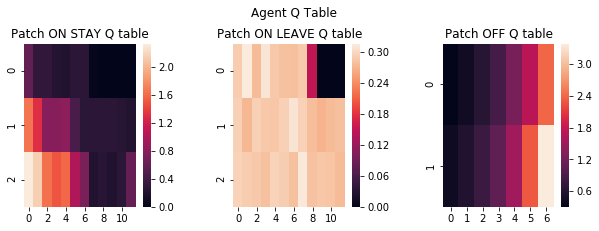

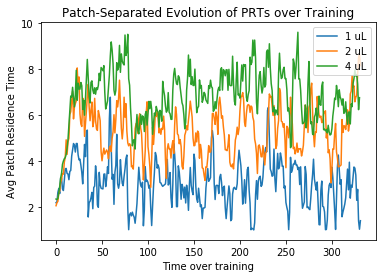

In [169]:
# run RL interface
env = PatchEnvironment('probabilistic',ITI_len = 7)

agent_type = 'Reward Size'
if agent_type == 'Reward Size':
    agent = RewSizeAgent(env.nTimestates,env.rewsizes,env.ITI_len,epsilon = .90,baseline_epsilon = .1)
if agent_type == 'Total Reward':
    agent = TotalRewAgent(env.nTimestates,max(env.rewsizes),env.ITI_len,epsilon = .90,baseline_epsilon = .1)
if agent_type == 'Omniscient':
    agent = OmniscentAgent(env.nTimestates,env.rewsizes,env.N0,env.ITI_len,epsilon = .90,baseline_epsilon = .1)

rl = RLInterface(agent,env)
print(rl.agent.epsilon)

# should add something so epsilon never goes to exactly 0
decisions = rl.run_trials(100000,epsilon_decay = 3000,record_decisions = True)

# # visualization
rl.show_qtable()
# rl.plot_percent_stay(decisions)
rl.plot_prts(100)  

'Mean:'

0.45263245627786897

'Std:'

1.124153512563435

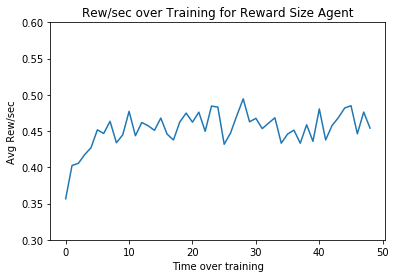

In [170]:
# assess agent efficiency
rl.plot_rewrate(10000,agent_type)


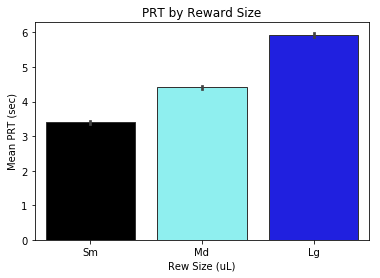

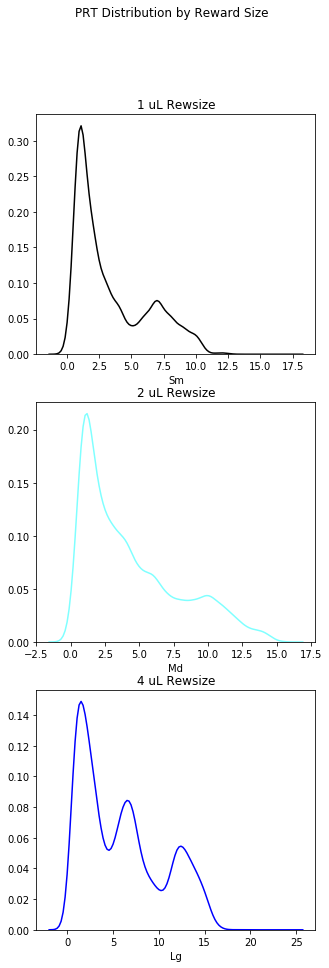

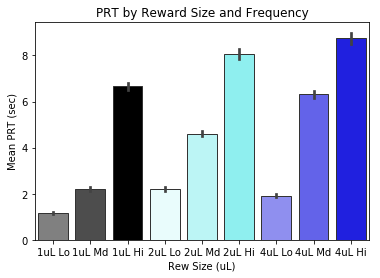

In [159]:
# mean PRT analysis
rl.prt_bars(10000)
rl.prt_hist(10000)
rl.prt_plus_bars(10000)

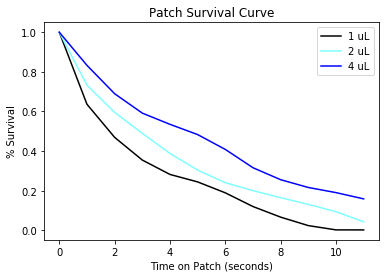

In [160]:
# timecourse analysis
rl.mk_timecourse()
rl.plot_survival()

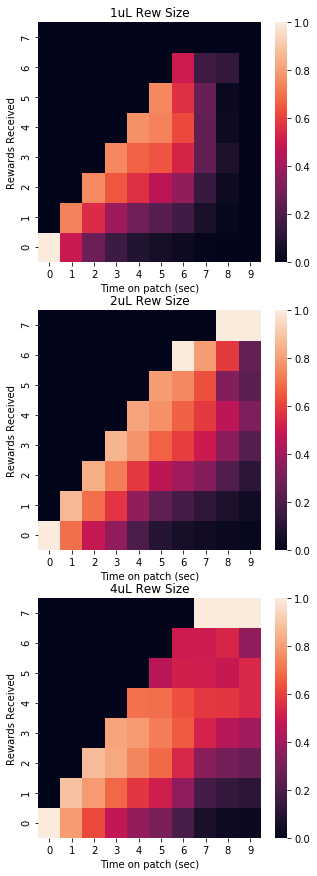

In [166]:
# make a function for plotting color density as percent patch residence
rl.percent_hmap([0,10],[25000,30000])

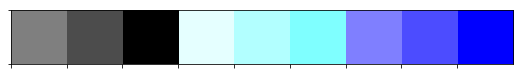

In [1227]:
# color testing!
colors = [(.5,.5,.5),(.3,.3,.3),(0,0,0),(.9,1,1),(.7,1,1),(.5,1,1),(.5,.5,1),(.3,.3,1),(0,0,1)]
sns.palplot(colors)


array([[0., 0.],
       [0., 0.]])

ValueError: Must pass 2-d input

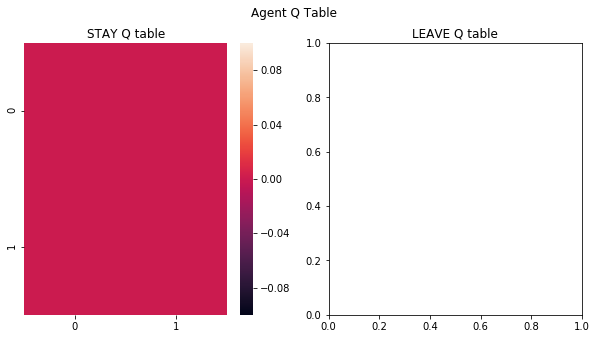

In [670]:
rl.show_qtable()
rl.agent.Q[ON][(1,1,15)] = 5
rl.show_qtable()

In [643]:
# agent tests
agent = RewSizeAgent(5,[1,2,4],2)
agent.curr_rewsize = 2
internal_state = agent.internalize_state([1,1])
display(internal_state)
display(agent.Q)
# display(agent.Q[STAY][1,1])
display(agent.Q[ON][internal_state])

agent.Q[ON][0][:,3]

(1, 1, 1)

[array([[0., 0.],
        [0., 0.]]), array([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])]

0.0

array([0., 0., 0.])

In [611]:
# patchy environment tests
patchy_env = PatchEnvironment('deterministic')
patchy_env.new_patch()
display(patchy_env.state)
for i in range(10):
    display(patchy_env.execute_action(STAY))
display(patchy_env.state)

[1, 0]

([1, 1], 0.0)

([1, 2], 0.0)

([1, 3], 0.0)

([1, 4], 1.0)

([1, 5], 0.0)

([1, 6], 0.0)

([1, 7], 0.0)

([1, 8], 0.0)

([1, 9], 0.0)

([1, 10], 0.0)

[1, 10]

In [545]:
[1,2,3].index(2)

1

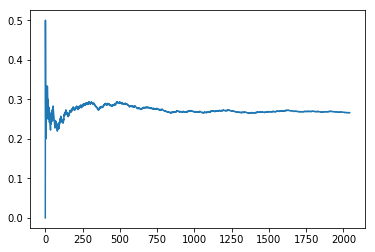

In [546]:
percent = [1 - sum(decisions[0:i])/i for i in range(1,len(decisions))]
plt.plot(percent)

In [625]:
# NEW Q TABLE DESIGN!!!

ITI_len = 2
n_actions = 2
num_obs_states = (3,10)
q = [np.zeros((n_actions,ITI_len)),np.zeros((n_actions,num_obs_states[0],num_obs_states[1]))]
display(q[OFF])
display(q[ON])

array([[0., 0.],
       [0., 0.]])

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [563]:
a = tuple((1,3,))

b,c = a[0],a[1]
b
list(a)

[1, 3]

In [945]:
dict_ = {1:[],2:[],3:[]}
dict_[1].append([4,4])
dict_

{1: [[4, 4]], 2: [], 3: []}

In [145]:
import itertools
a = [1,2,4]
b = [.125,.25,.5]
c = list(itertools.product(b, repeat = 2))
c

[(0.125, 0.125),
 (0.125, 0.25),
 (0.125, 0.5),
 (0.25, 0.125),
 (0.25, 0.25),
 (0.25, 0.5),
 (0.5, 0.125),
 (0.5, 0.25),
 (0.5, 0.5)]

In [58]:
a = rnd.normal(0,.1,100)
a

array([-0.05275672,  0.03649439, -0.00507939,  0.01220159, -0.16008539,
        0.10395104,  0.05153106, -0.10828129,  0.0098629 ,  0.02871571,
       -0.10660487,  0.0958759 ,  0.04439161, -0.07904715, -0.0609281 ,
        0.01723251, -0.15756184, -0.09538755,  0.19941693, -0.17682815,
        0.02679911,  0.08720625,  0.02843193,  0.01761012, -0.01483308,
        0.02989352, -0.00952854, -0.09561717,  0.01674165,  0.00226274,
        0.18812302, -0.13925049, -0.05070979, -0.08679829,  0.21548067,
        0.05643779, -0.03898856, -0.02193816,  0.00094327, -0.05773032,
        0.17275875, -0.02297834, -0.02062266,  0.18246465,  0.14917585,
       -0.01731343, -0.04321416, -0.09080452, -0.0346125 , -0.01558974,
        0.09907387,  0.01904509, -0.14317135, -0.05496251, -0.09390957,
       -0.1592723 , -0.21844666, -0.00830898, -0.11561523, -0.02853376,
       -0.05683584, -0.03956916,  0.00250723, -0.07202673,  0.03033196,
        0.06202512,  0.02756945,  0.03823321, -0.07757505, -0.08